In this post I'll try to show how from a screenshot obtained from a software like Spotify you can programmatically extract the tracks of the songs as well as the artists, to finally download them from the Internet.


<!-- TEASER_END -->
I'll use the python programming language as well as different libraries that are available as open source.

# Extracting images from source files


We start with a series of files in PNG format. They correspond to screenshots that you can easily obtain with your usual operating system, whether it is MacOS Windows. I received this from a friend to remind memories of a good party...

For this first step we use the pillow library that allows us to transform this image file into a numpy matrix:

In [2]:
from PIL import Image
import numpy as np

In [3]:
filename = 'raw/Capture d\'écran 2020-04-20 16.19.32.png'
img1 = np.array(Image.open(filename))

In [4]:
print(f'{img1.shape=}')

img1.shape=(2100, 3360, 4)


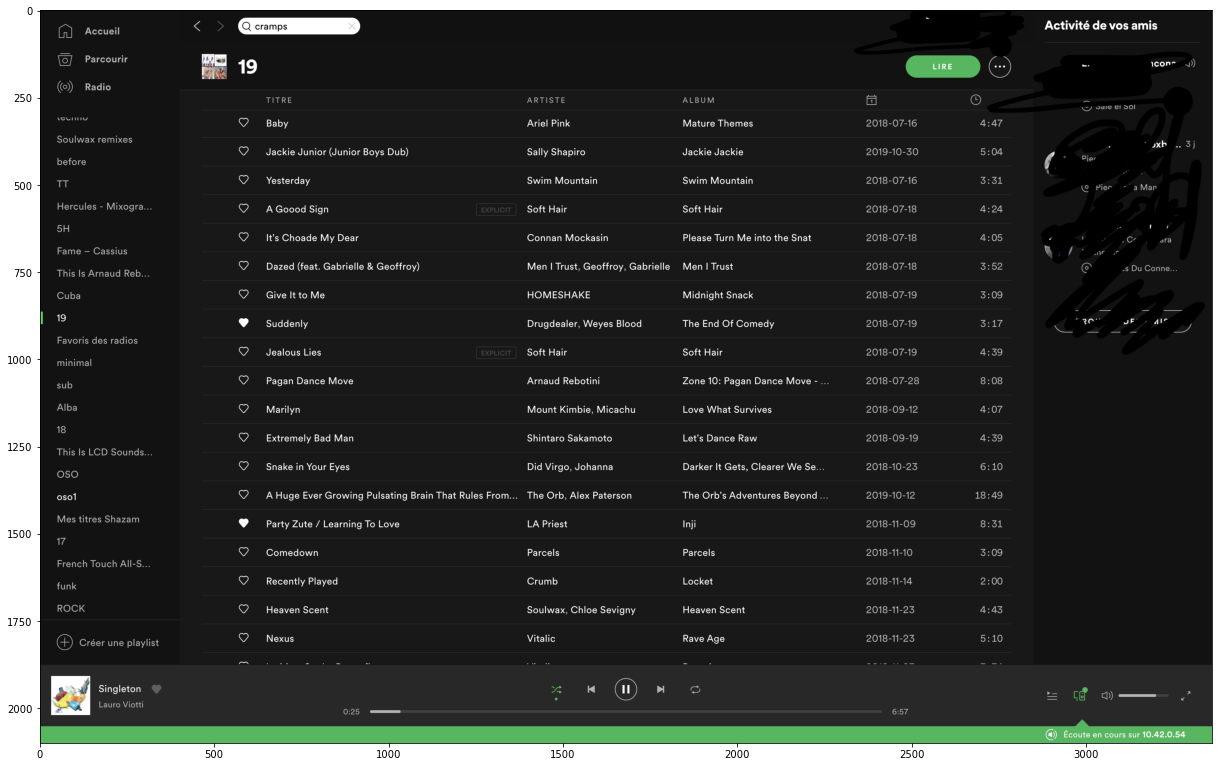

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax  = plt.subplots(figsize=(21, 15))
ax.imshow(img1);

## crop


The display of this image allows us to see that we will be able to extract an area of interest that will be the same for the other screenshots... It is easily found by hand and we will check below that it works for all the images.

These images are stored in a folder and we will use the glob library to extract them one by one.

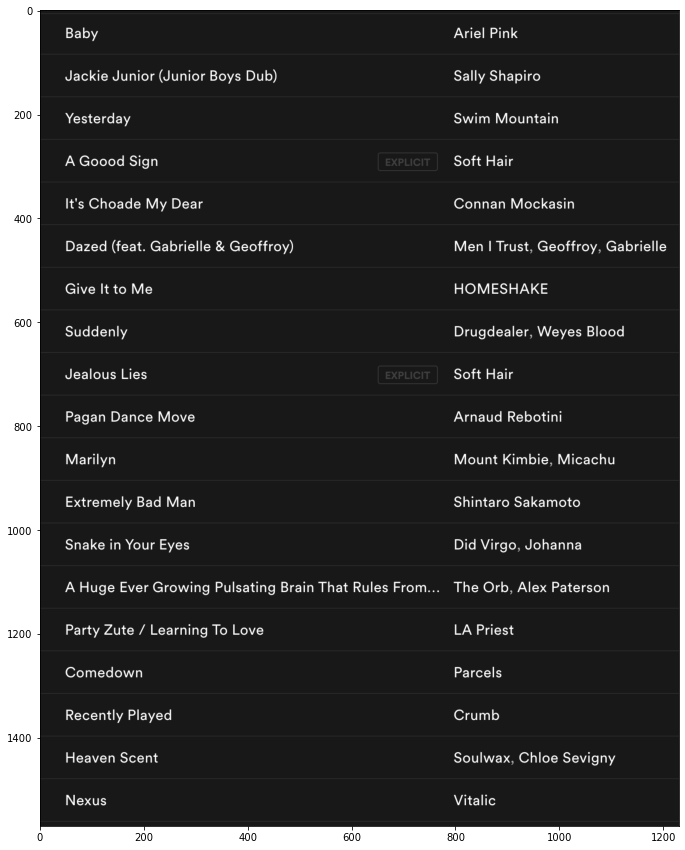

In [6]:
l, r, t, b = 600, 1830, 280, 1850
fig, ax  = plt.subplots(figsize=(21, 15))
ax.imshow(img1[t:b, l:r, :]);

Let's now extract a binary image from that:

img.min()=81.75 img.max()=255.0


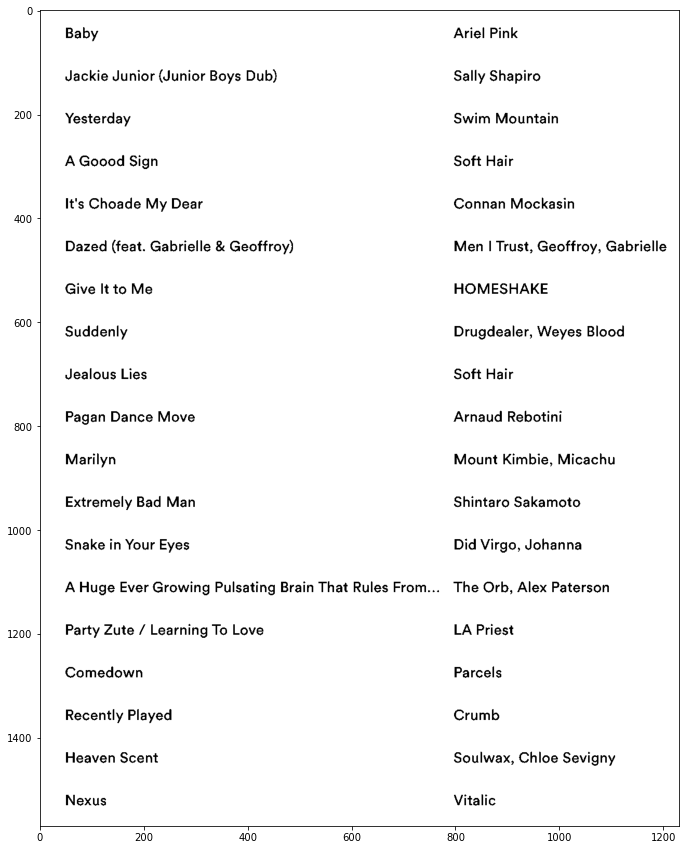

In [7]:
img = img1[t:b, l:r, :]
img = img.mean(axis=-1)
print(f'{img.min()=} {img.max()=}')
img = img < 128
fig, ax  = plt.subplots(figsize=(21, 15))
ax.imshow(img, cmap=plt.gray());

## OCR: Extracting text from the images

The next step is to extract the text from the images we have loaded from our folder. For this, we will use an optical character recognition software aka OCR. A library developed by Google and which is entirely open source allows us to do this in a few lines.

The library expect black text on the white background :

https://tesseract-ocr.github.io/tessdoc/ImproveQuality.html

(for more info, see
https://towardsdatascience.com/create-simple-optical-character-recognition-ocr-with-python-6d90adb82bb8 )

In [8]:
%conda install -c conda-forge pytesseract 

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pytesseract
text = pytesseract.image_to_string(img)
LC = text[:-1].replace('\n\n', '\n').split('\n')
print(f'{len(LC)=}')

len(LC)=39


In [10]:
print (text)

Baby

Jackie Junior (Junior Boys Dub)
Yesterday

A Goood Sign

It's Choade My Dear

Dazed (feat. Gabrielle & Geoffroy)
Give It to Me

Suddenly

Jealous Lies

Pagan Dance Move

Marilyn

Extremely Bad Man

Snake in Your Eyes

A Huge Ever Growing Pulsating Brain That Rules From...

Party Zute / Learning To Love

Comedown

Recently Played

Heaven Scent

Nexus

Ariel Pink

Sally Shapiro

Swim Mountain

Soft Hair

Connan Mockasin

Men | Trust, Geoffroy, Gabrielle

HOMESHAKE

Drugdealer, Weyes Blood

Soft Hair

Arnaud Rebotini

Mount Kimbie, Micachu

Shintaro Sakamoto

Did Virgo, Johanna

The Orb, Alex Paterson

LA Priest

Parcels

Crumb

Soulwax, Chloe Sevigny

Vitalic



Note that the library expects black text on the white background :

https://tesseract-ocr.github.io/tessdoc/ImproveQuality.html

(see the image processing above to see how it was done).

We can see that the extracted text corresponds well to the first and then to the second column in the image.

We can now store this information in a pandas type table:

In [11]:
%conda install -c conda-forge pandas 

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
songs = []
import pandas as pd
songs = pd.DataFrame([], columns=['title', 'artist']) 
for i in range(len(LC)//2):
    songs.loc[i] = {'title':LC[i], 'artist':LC[i+len(LC)//2]}
songs

title  \
0                                                Baby   
1                     Jackie Junior (Junior Boys Dub)   
2                                           Yesterday   
3                                        A Goood Sign   
4                                 It's Choade My Dear   
5                  Dazed (feat. Gabrielle & Geoffroy)   
6                                       Give It to Me   
7                                            Suddenly   
8                                        Jealous Lies   
9                                    Pagan Dance Move   
10                                            Marilyn   
11                                  Extremely Bad Man   
12                                 Snake in Your Eyes   
13  A Huge Ever Growing Pulsating Brain That Rules...   
14                      Party Zute / Learning To Love   
15                                           Comedown   
16                                    Recently Played   
17                                       Heaven Scent   
18                                              Nexus   

                              artist  
0                         Ariel Pink  
1                      Sally Shapiro  
2                      Swim Mountain  
3                          Soft Hair  
4                    Connan Mockasin  
5   Men | Trust, Geoffroy, Gabrielle  
6                          HOMESHAKE  
7            Drugdealer, Weyes Blood  
8                          Soft Hair  
9                    Arnaud Rebotini  
10             Mount Kimbie, Micachu  
11                 Shintaro Sakamoto  
12                Did Virgo, Johanna  
13            The Orb, Alex Paterson  
14                         LA Priest  
15                           Parcels  
16                             Crumb  
17            Soulwax, Chloe Sevigny  
18                           Vitalic

## batch of images

Applying this on the set of screenshots, we have:

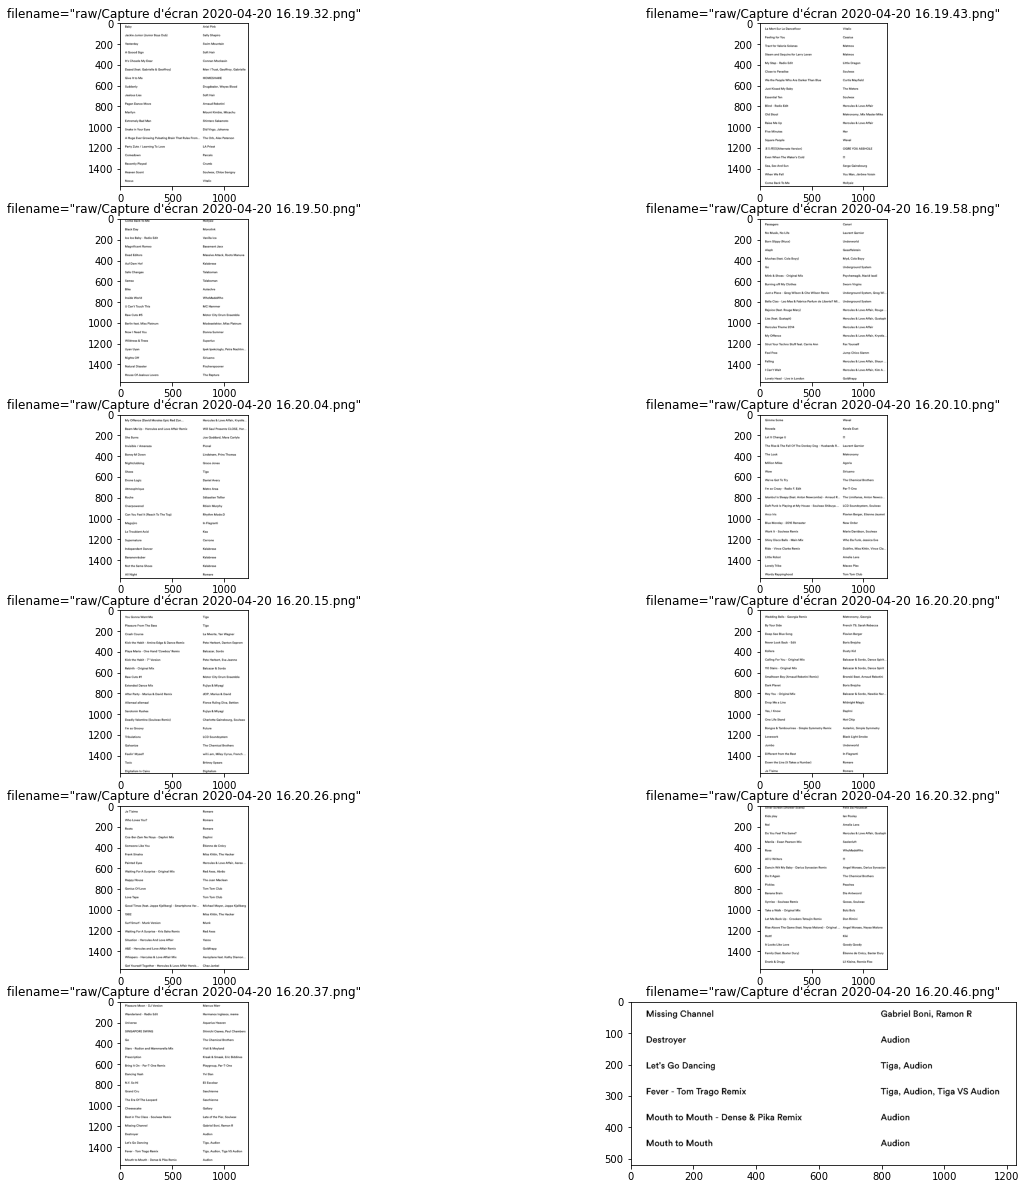

In [13]:
import glob
filenames = sorted(glob.glob('raw/*.png'))

fig, axs  = plt.subplots(len(filenames)//2, 2, figsize=(21, 21))

for filename, ax in zip(filenames, axs.ravel()):
    img1 = np.array(Image.open(filename))
    l, r, t, b = 600, 1830, 280, 1850

    if filename=="raw/Capture d'écran 2020-04-20 16.20.46.png": b = 800
        
    img = img1[t:b, l:r, :]
    img = img.mean(axis=-1)
    #print(f'{img.min()=} {img.max()=}')
    img = img < 128
    ax.set_title(f'{filename=}')
    ax.imshow(img, cmap=plt.gray());


So that the pandas files is constructed using:

In [14]:
cache_filename = 'songs.json'
import os
if not os.path.isfile(cache_filename):
    import glob
    import pandas as pd
    songs = pd.DataFrame([], columns=['title', 'artist']) 
    i_song = 0
    for filename in glob.glob('raw/*.png'):
        #print(f'{filename=}')
        img1 = np.array(Image.open(filename))
        l, r, t, b = 600, 1830, 280, 1850

        if filename=="raw/Capture d'écran 2020-04-20 16.20.46.png": b = 800

        img = img1[t:b, l:r, :]
        img = img.mean(axis=-1)
        #print(f'{img.min()=} {img.max()=}')
        img = img < 128

        import pytesseract
        text = pytesseract.image_to_string(img)
        LC = text[:-1].replace('\n\n', '\n').split('\n')

        #print(f'{len(LC)=}')
        for i in range(len(LC)//2):
            songs.loc[i_song] = {'title':LC[i], 'artist':LC[i+len(LC)//2]}
            i_song += 1 
    songs.to_json(cache_filename)
else:
    songs = pd.read_json(cache_filename)
songs

title             artist
0                                           Gimme Some              Weval
1                                               Nevada        Kerala Dust
2                                      Let It Change U    Laurent Garnier
3    The Rise & The Fall Of The Donkey Dog - Husban...          Metronomy
4                                             The Look             Agoria
..                                                 ...                ...
210                                           Lovework  Black Light Smoke
211                                              Jumbo         Underworld
212                            Different from the Rest       In Flagranti
213                  Down the Line (It Takes a Number)             Romare
214                                          Je T’aime             Romare

[215 rows x 2 columns]


# one more thing...

It's incredible how easy it is nowadays to do these operations! To be able to extract the information you wanted from an image so quickly was not imagniable a few years ago... This is one of the many advantages that emerge from the numerour existing collaborations in the fields of computer vision and artificial intelligence.

Can we go one step further and extract an audio file from this information?

A first step would be to try to find a [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) from a search query containing the title and the artist. To do this, we will use the [DuckDuckGo](https://duckduckgo.com) search engine, and use the [DuckPy](https://pypi.org/project/duckpy/) library to do this programmatically:



## ...searching on DuckDuckGo ...

In [15]:
%pip install duckpy 

Note: you may need to restart the kernel to use updated packages.


In [17]:
import time
songs_results = pd.DataFrame([], columns=['i_song', 'rank', 'title', 'url', 'description']) 

cache_filename = 'songs_results.json'
import os
if os.path.isfile(cache_filename):
    songs_results = pd.read_json(cache_filename)

for i_song in range(len(songs)):
    if len(songs_results[songs_results['i_song']==i_song])==0:
        artist = songs.loc[i_song]['artist']
        title = songs.loc[i_song]['title']
        
        if '...' in title: # cut last word
            title = title.rsplit(' ', 1)[0]

        print(50*'-')
        print(f'{i_song} ----- {title} ({artist}) ')
        print(50*'-')

        search_pattern = f'{title} {artist} site:www.youtube.com -playlist'

        from duckpy import Client
        client = Client()
        results = client.search(search_pattern)
        print(f'{search_pattern=}, {len(results)=}')
        time.sleep(10.) # graciously wait
        if len(results) > 0:
            for rank, result in enumerate(results):
                result['rank'] = rank
                result['i_song'] = i_song
                songs_results = songs_results.append(result, ignore_index=True)        
songs_results.to_json(cache_filename)

songs_results

--------------------------------------------------
0 ----- Gimme Some (Weval) 
--------------------------------------------------
search_pattern='Gimme Some Weval site:www.youtube.com -playlist', len(results)=14
--------------------------------------------------
1 ----- Nevada (Kerala Dust) 
--------------------------------------------------
search_pattern='Nevada Kerala Dust site:www.youtube.com -playlist', len(results)=7
--------------------------------------------------
2 ----- Let It Change U (Laurent Garnier) 
--------------------------------------------------
search_pattern='Let It Change U Laurent Garnier site:www.youtube.com -playlist', len(results)=19
--------------------------------------------------
3 ----- The Rise & The Fall Of The Donkey Dog - Husbands (Metronomy) 
--------------------------------------------------
search_pattern='The Rise & The Fall Of The Donkey Dog - Husbands Metronomy site:www.youtube.com -playlist', len(results)=28
-----------------------------------

i_song rank                                              title  \
0         0    0                       Weval - Gimme Some - YouTube   
1         0    1                       Weval - Gimme Some - YouTube   
2         0    2                       Weval - Gimme Some - YouTube   
3         0    3                       WEVAL - GIMME SOME - YouTube   
4         0    4        Weval - Gimme Some / Carlos Ojeda - YouTube   
...     ...  ...                                                ...   
3652    214   17  FRANCIS CABREL je t'aimais je t'aime et je t'a...   
3653    214   18       michel Sardou je t'aime, je t'aime - YouTube   
3654    214   19  Axel Tony - Je t'aimais, je t'aime et je t'aim...   
3655    214   20        Lara Fabian Je t'aime avec parole - YouTube   
3656    214   21  Tuto Guitare #4 :Francis Cabrel - je t'aimais ...   

                                              url  \
0     https://www.youtube.com/watch?v=lXDhCBHu-S8   
1     https://www.youtube.com/watch?v=O8YCoutpCJ0   
2     https://www.youtube.com/watch?v=OXqp-nu7H9c   
3     https://www.youtube.com/watch?v=J1J3b3PiOrQ   
4     https://www.youtube.com/watch?v=KFbP6Rn6OIE   
...                                           ...   
3652  https://www.youtube.com/watch?v=gVJDd36K0ls   
3653  https://www.youtube.com/watch?v=ykONfeFGP6Q   
3654  https://www.youtube.com/watch?v=fgL76dFKVEE   
3655  https://www.youtube.com/watch?v=mlUA4M-LpMw   
3656  https://www.youtube.com/watch?v=R36oAlryEG8   

                                            description  
0     Weval - Gimme Some 'Easier' EP A new EP from m...  
1      Weval - Gimme Some. 322 просмотра 322 просмотра.  
2     Weval - Gimme Some. Music Gets Me High. Загруз...  
3     WEVAL - GIMME SOME No mates the video is OK. H...  
4     Música: Weval - Gimme Some Coreografía y Baila...  
...                                                 ...  
3652  Les Accords,( g d c em refrain; c am d c d c e...  
3653  Michel Sardou je t'aime, je t'aime, un bon vie...  
3654  Francis Cabrel - Je t'aimais, je t'aime, je t'...  
3655  Lara Fabian - Je T'aime Lyrics. Mücahit Elif I...  
3656  Salut salut, Me voici pour un quatrième tutori...  

[3657 rows x 5 columns]

## ... scoring heuristics ...

I was not completely happy with the raw search results, so I added some *magical* heuristics to select among all results:

In [18]:
songs_results

i_song rank                                              title  \
0         0    0                       Weval - Gimme Some - YouTube   
1         0    1                       Weval - Gimme Some - YouTube   
2         0    2                       Weval - Gimme Some - YouTube   
3         0    3                       WEVAL - GIMME SOME - YouTube   
4         0    4        Weval - Gimme Some / Carlos Ojeda - YouTube   
...     ...  ...                                                ...   
3652    214   17  FRANCIS CABREL je t'aimais je t'aime et je t'a...   
3653    214   18       michel Sardou je t'aime, je t'aime - YouTube   
3654    214   19  Axel Tony - Je t'aimais, je t'aime et je t'aim...   
3655    214   20        Lara Fabian Je t'aime avec parole - YouTube   
3656    214   21  Tuto Guitare #4 :Francis Cabrel - je t'aimais ...   

                                              url  \
0     https://www.youtube.com/watch?v=lXDhCBHu-S8   
1     https://www.youtube.com/watch?v=O8YCoutpCJ0   
2     https://www.youtube.com/watch?v=OXqp-nu7H9c   
3     https://www.youtube.com/watch?v=J1J3b3PiOrQ   
4     https://www.youtube.com/watch?v=KFbP6Rn6OIE   
...                                           ...   
3652  https://www.youtube.com/watch?v=gVJDd36K0ls   
3653  https://www.youtube.com/watch?v=ykONfeFGP6Q   
3654  https://www.youtube.com/watch?v=fgL76dFKVEE   
3655  https://www.youtube.com/watch?v=mlUA4M-LpMw   
3656  https://www.youtube.com/watch?v=R36oAlryEG8   

                                            description  
0     Weval - Gimme Some 'Easier' EP A new EP from m...  
1      Weval - Gimme Some. 322 просмотра 322 просмотра.  
2     Weval - Gimme Some. Music Gets Me High. Загруз...  
3     WEVAL - GIMME SOME No mates the video is OK. H...  
4     Música: Weval - Gimme Some Coreografía y Baila...  
...                                                 ...  
3652  Les Accords,( g d c em refrain; c am d c d c e...  
3653  Michel Sardou je t'aime, je t'aime, un bon vie...  
3654  Francis Cabrel - Je t'aimais, je t'aime, je t'...  
3655  Lara Fabian - Je T'aime Lyrics. Mücahit Elif I...  
3656  Salut salut, Me voici pour un quatrième tutori...  

[3657 rows x 5 columns]

In [19]:
songs_winner = pd.DataFrame([], columns=['i_song', 'score', 'title', 'url', 'description']) 

for i_song in range(len(songs)):
    if len(songs_results[songs_results['i_song']==i_song])>0:
        song_results = songs_results[songs_results['i_song']==i_song].copy()
        song_results['score'] = 0
        for rank, result in enumerate(song_results.iterrows()):  
            song_results['score'] = int(1000 * (0.9) ** rank)
            if songs.loc[i_song, 'title'] in song_results['title']:
                song_results['score'] += 500
            if songs.loc[i_song, 'artist'] in song_results['title']:
                song_results['score'] += 500
            if songs.loc[i_song, 'title'] in song_results['description']:
                song_results['score'] += 200
            if songs.loc[i_song, 'artist'] in song_results['description']:
                song_results['score'] += 200

        i_winner = song_results['score'].argmax()
        songs_winner.loc[i_song] = song_results.iloc[song_results['score'].argmax()]
songs_winner['artist'] = songs['artist']
songs_winner['songtitle'] = songs['title']

In [22]:
from IPython.display import display, HTML
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_html.html#pandas.DataFrame.to_html
display(HTML(songs_winner[['i_song','score', 'title', 'artist', 'songtitle']].to_html()))

In [21]:
songs_results[songs_results['i_song']==11]

i_song rank                                              title  \
215     11    0  MC Arco lris --- Bonde Colorido ( canal da bib...   
216     11    1  LRİS EVRİM GEÇİRDİ! NEW BREKING LRIS EFSANE - ...   
217     11    2  Danza de jóvenes de Templo Elim de la Barriada...   
218     11    3                      O arco-lris mágicos - YouTube   
219     11    4  New Order - Crystal & Regret (Live Finsbury Pa...   
220     11    5                          Arco lris doble - YouTube   
221     11    6                  Fazendo balão arco lris - YouTube   
222     11    7  El arco compuesto y para que sirve - Cronicas ...   
223     11    8  MHW Iceborne | Novos Moves e Combos do ARCO / ...   
224     11    9                       Otávio Arco_ĺris10 - YouTube   
225     11   10  MHW Iceborne - Builds de Bow / Arco Adaptativa...   
226     11   11  YORICK ARCO DE LUZ (1350 RP) NUEVA SKIN! - You...   
227     11   12    ИСТОРИЯ МИРА - ЛОР МОДА The New Order - YouTube   
228     11   13  Arco-Íris Doloroso | As Meninas Superpoderosas...   
229     11   14      My Little Pony Corrida Arco-Íris #1 - YouTube   
230     11   15  Arco-Flagellants And Repentia Superior Reveale...   
231     11   16  FINAL FANTASY XV Os Sapos Lendários - Localiza...   
232     11   17  Destiny 2: COMO CONSEGUIR ALIENTO DEL LEVIATAN...   
233     11   18                      New Order - Sunrise - YouTube   
234     11   19          Ministério Arco Iris Mozambique - YouTube   
235     11   20  LA VETA EN LOS ARCOS DE MADERA - Arquería Trad...   
236     11   21  ESO Complete Psijic Order Guide (2020) | All R...   
237     11   22  Skyrim - Dawnguard DLC: 'A New Order' Quest - ...   

                                                   url  \
215        https://www.youtube.com/watch?v=58AXI11zLRw   
216        https://www.youtube.com/watch?v=gigiAYIj2zg   
217        https://www.youtube.com/watch?v=qZk0CvnMB_E   
218        https://www.youtube.com/watch?v=OEcGqkFjh8M   
219        https://www.youtube.com/watch?v=srN4BpOWPJ4   
220        https://www.youtube.com/watch?v=Ip7b3QIovpQ   
221        https://www.youtube.com/watch?v=ZgfHhp_o4lk   
222        https://www.youtube.com/watch?v=E2nGV2YHg1c   
223        https://www.youtube.com/watch?v=GCNvrf34nGo   
224  https://www.youtube.com/channel/UCn0hqrvg3uDk2...   
225        https://www.youtube.com/watch?v=d82Ea8oJZwY   
226        https://www.youtube.com/watch?v=9o38r4F_iJg   
227        https://www.youtube.com/watch?v=1ObVjtFdmRM   
228        https://www.youtube.com/watch?v=ePtB4V9hFwU   
229        https://www.youtube.com/watch?v=se8V8Zrilmk   
230        https://www.youtube.com/watch?v=L6WTfy6sbAU   
231        https://www.youtube.com/watch?v=P31ppRW-iA8   
232        https://www.youtube.com/watch?v=8P04oGdftlo   
233        https://www.youtube.com/watch?v=KQfV-9tv6Ag   
234        https://www.youtube.com/watch?v=nvGaIr3Gpsc   
235        https://www.youtube.com/watch?v=r6fyramzu24   
236        https://www.youtube.com/watch?v=GPJvUD9iIr8   
237        https://www.youtube.com/watch?v=0JhlDp0aHPE   

                                           description  
215  Mc Arco Iris 🌈 Alice Monteiro - Melhores Amiga...  
216  NEW BREKING LRIS EFSANE | B37 Ark Tranformatio...  
217  Danza de jóvenes de Templo Elim de la Barriada...  
218  Se escreva no meu canal. Espero que goste Nome...  
219  All rights reserved of the copyright holder, p...  
220  Отмена. Месяц бесплатно. Arco lris doble. Will...  
221  Fazendo balão arco lris. Marly Rodrigues. Загр...  
222  En este video vamos a ver para que sirve el ar...  
223  Monster Hunter World | Bow - Arco Tutorial / G...  
224  Otávio Arco_ĺris10. Otávio Arco_ĺris10. 6 подп...  
225  Caçada Shara Ishvalda de Arco Divindade de Vel...  
226  New arclight yorick jungle spotlight | this sk...  
227  Hoi4 The New Order Heydrichs Germany! Mountain...  
228  Oggy & Zig & Sharko Season 2 NEW BEST COMPILAT...  
229  Corra, pule e voe para restaurar as cores do m...  
230  Следующее. Si

Seems all good!

## ...one last thing: grabbing the audio?

In particular, we manage to extract the URI that we could find on the YouTube site :


In [23]:
%conda install -c conda-forge  youtube-dl

Solving environment: done

## Package Plan ##

  environment location: /usr/local/anaconda3/envs/cv

  added / updated specs:
    - youtube-dl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    youtube-dl-2020.11.24      |   py38h50d1736_0         2.3 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following packages will be UPDATED:

  youtube-dl                    2020.11.21.1-py38h50d1736_0 --> 2020.11.24-py38h50d1736_0



youtube-dl-2020.11.2 | 2.3 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.



From this information we just have to use the YouTube-DL library. As this one is written in python, we can also use its programming interface to finalize our program:


In [24]:
import os
for i_song in range(len(songs)):
    artist = songs.loc[i_song]['artist']
    title = songs.loc[i_song]['title']
    print(50*'-')
    print(f'{i_song} ----- {title} ({artist}) ')
    print(50*'-')

    import youtube_dl

    ext='opus'
    filename = f"playlist/{i_song}_{artist}_{title}.{ext}"
    if not os.path.isfile(filename):
        # more options @ https://github.com/ytdl-org/youtube-dl#embedding-youtube-dl
        ydl_opts = {
                'extractaudio': True,       
                'noplaylist': True,
                'format': 'bestaudio/best',
                'outtmpl': filename,
                'postprocessors': [{
                    'key': 'FFmpegExtractAudio',
                    'preferredcodec': ext,
                    'preferredquality': '192',
                }],
            }

        try:
            with youtube_dl.YoutubeDL(ydl_opts) as ydl:
                ydl.download([songs_winner.loc[i_song]['url']])
        except:
            pass

--------------------------------------------------
0 ----- Gimme Some (Weval) 
--------------------------------------------------
[youtube] lXDhCBHu-S8: Downloading webpage
[youtube] Downloading just video lXDhCBHu-S8 because of --no-playlist
[download] Destination: playlist/0_Weval_Gimme Some.opus
[download] 100% of 4.94MiB in 00:11.91KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/0_Weval_Gimme Some.opus exists, skipping
--------------------------------------------------
1 ----- Nevada (Kerala Dust) 
--------------------------------------------------
[youtube] 5KMlER4cZLc: Downloading webpage
[youtube] 5KMlER4cZLc: Downloading embed webpage
[youtube] 5KMlER4cZLc: Refetching age-gated info webpage
[youtube] Downloading just video 5KMlER4cZLc because of --no-playlist
[download] Destination: playlist/1_Kerala Dust_Nevada.opus
[download] 100% of 6.11MiB in 00:10.61KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/1_Kerala Dust_Nevada.opus exists, skipping
--------------------------

ERROR: fiytVLbH81U: YouTube said: Unable to extract video data


--------------------------------------------------
27 ----- Atmosphrique (Metro Area) 
--------------------------------------------------
[youtube] N4FDj_Id4ec: Downloading webpage
[youtube] Downloading just video N4FDj_Id4ec because of --no-playlist
[download] Destination: playlist/27_Metro Area_Atmosphrique.opus
[download] 100% of 34.82MiB in 05:11.10KiB/s ETA 00:0055
[ffmpeg] Post-process file playlist/27_Metro Area_Atmosphrique.opus exists, skipping
--------------------------------------------------
28 ----- Roche (Sébastien Tellier) 
--------------------------------------------------
[youtube] T0k6rXkP3vI: Downloading webpage
[youtube] Downloading just video T0k6rXkP3vI because of --no-playlist
[download] Destination: playlist/28_Sébastien Tellier_Roche.opus
[download] 100% of 2.73MiB in 00:05.83KiB/s ETA 00:00
[ffmpeg] Correcting container in "playlist/28_Sébastien Tellier_Roche.opus"
[ffmpeg] Post-process file playlist/28_Sébastien Tellier_Roche.opus exists, skipping
-----------

ERROR: This video is not available.


--------------------------------------------------
54 ----- Sea, Sex And Sun (You Man, Jéréme Voisin) 
--------------------------------------------------
[youtube] -lsVsg4wyk4: Downloading webpage
[youtube] Downloading just video -lsVsg4wyk4 because of --no-playlist
[download] Destination: playlist/54_You Man, Jéréme Voisin_Sea, Sex And Sun.opus
[download] 100% of 3.81MiB in 00:11.93KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/54_You Man, Jéréme Voisin_Sea, Sex And Sun.opus exists, skipping
--------------------------------------------------
55 ----- When We Fall (Hollysiz) 
--------------------------------------------------
[youtube] M5ux3qtfWU4: Downloading webpage
[youtube] Downloading just video M5ux3qtfWU4 because of --no-playlist
[download] Destination: playlist/55_Hollysiz_When We Fall.opus
[download] 100% of 18.22MiB in 01:12.04KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/55_Hollysiz_When We Fall.opus exists, skipping
-----------------------------------------------

ERROR: This video contains content from SME, who has blocked it in your country on copyright grounds.


--------------------------------------------------
94 ----- Digitalism In Cairo (Digitalism) 
--------------------------------------------------
[youtube] UEfBekgSwCQ: Downloading webpage
[youtube] Downloading just video UEfBekgSwCQ because of --no-playlist
[download] Destination: playlist/94_Digitalism_Digitalism In Cairo.opus
[download] 100% of 5.06MiB in 00:11.16KiB/s ETA 00:00
[ffmpeg] Correcting container in "playlist/94_Digitalism_Digitalism In Cairo.opus"
[ffmpeg] Post-process file playlist/94_Digitalism_Digitalism In Cairo.opus exists, skipping
--------------------------------------------------
95 ----- Baby (Ariel Pink) 
--------------------------------------------------
[youtube] 7rTolZkCkH8: Downloading webpage
[youtube] Downloading just video 7rTolZkCkH8 because of --no-playlist
[download] Destination: playlist/95_Ariel Pink_Baby.opus
[download] 100% of 4.51MiB in 00:16.36KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/95_Ariel Pink_Baby.opus exists, skipping
----------

ERROR: This video is not available.


--------------------------------------------------
151 ----- Take a Walk - Original Mix (Bolz Bolz) 
--------------------------------------------------
[youtube] Hb-txdiRVWQ: Downloading webpage
[youtube] Downloading just video Hb-txdiRVWQ because of --no-playlist
[download] Destination: playlist/151_Bolz Bolz_Take a Walk - Original Mix.opus
[download] 100% of 6.85MiB in 00:15.23KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/151_Bolz Bolz_Take a Walk - Original Mix.opus exists, skipping
--------------------------------------------------
152 ----- Let Me Back Up - Crookers Tetsujin Remix (Don Rimini) 
--------------------------------------------------
[youtube] 7q6ezlZ7yLw: Downloading webpage
[youtube] Downloading just video 7q6ezlZ7yLw because of --no-playlist
[download] Destination: playlist/152_Don Rimini_Let Me Back Up - Crookers Tetsujin Remix.opus
[download] 100% of 5.70MiB in 00:12.34KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/152_Don Rimini_Let Me Back Up - Crooker

ERROR: This video is not available.


--------------------------------------------------
166 ----- Dancing Yeah (Yvi Slan) 
--------------------------------------------------
[youtube] oNY_lDJ3zc8: Downloading webpage
[youtube] Downloading just video oNY_lDJ3zc8 because of --no-playlist
[youtube] oNY_lDJ3zc8: Downloading MPD manifest
[dashsegments] Total fragments: 22
[download] Destination: playlist/166_Yvi Slan_Dancing Yeah.opus
[download] 100% of 3.23MiB in 00:152.84KiB/s ETA 00:0018
[ffmpeg] Post-process file playlist/166_Yvi Slan_Dancing Yeah.opus exists, skipping
--------------------------------------------------
167 ----- N.Y. So Hi (Eli Escobar) 
--------------------------------------------------
[youtube] 31rSx-BRo6Y: Downloading webpage
[youtube] Downloading just video 31rSx-BRo6Y because of --no-playlist
[download] Destination: playlist/167_Eli Escobar_N.Y. So Hi.opus
[download] 100% of 5.04MiB in 00:10.67KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/167_Eli Escobar_N.Y. So Hi.opus exists, skipping
-------

ERROR: This video contains content from WMG, who has blocked it on copyright grounds.


--------------------------------------------------
181 ----- Muchas (feat. Cola Boyy) (Myd, Cola Boyy) 
--------------------------------------------------
[youtube] I7fCOrj26ow: Downloading webpage
[youtube] Downloading just video I7fCOrj26ow because of --no-playlist
[download] Destination: playlist/181_Myd, Cola Boyy_Muchas (feat. Cola Boyy).opus
[download] 100% of 2.98MiB in 00:06.83KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/181_Myd, Cola Boyy_Muchas (feat. Cola Boyy).opus exists, skipping
--------------------------------------------------
182 ----- Go (Underground System) 
--------------------------------------------------
[youtube] MEMABFkzCdA: Downloading webpage
[youtube] Downloading just video MEMABFkzCdA because of --no-playlist
[download] Destination: playlist/182_Underground System_Go.opus
[download] 100% of 4.39MiB in 00:10.24KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/182_Underground System_Go.opus exists, skipping
------------------------------------------

[generic] MPREb_8Sahte9fA5R: Downloading webpage
[generic] MPREb_8Sahte9fA5R: Extracting information


ERROR: Unsupported URL: https://music.youtube.com/browse/MPREb_8Sahte9fA5R


--------------------------------------------------
188 ----- Lies (feat. Gustaph) (Hercules & Love Affair, Gustaph) 
--------------------------------------------------
[youtube] cumLsj9h0G8: Downloading webpage
[youtube] Downloading just video cumLsj9h0G8 because of --no-playlist
[download] Destination: playlist/188_Hercules & Love Affair, Gustaph_Lies (feat. Gustaph).opus
[download] 100% of 6.19MiB in 00:14.61KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/188_Hercules & Love Affair, Gustaph_Lies (feat. Gustaph).opus exists, skipping
--------------------------------------------------
189 ----- Hercules Theme 2014 (Hercules & Love Affair) 
--------------------------------------------------
[youtube] MLO4MNY0dOk: Downloading webpage
[youtube] Downloading just video MLO4MNY0dOk because of --no-playlist
[download] Destination: playlist/189_Hercules & Love Affair_Hercules Theme 2014.opus
[download] 100% of 2.49MiB in 00:05.80KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/189_Hercu

ERROR: This video contains content from WMG, who has blocked it in your country on copyright grounds.


--------------------------------------------------
193 ----- Falling (Hercules & Love Affair, Shaun ...) 
--------------------------------------------------
[youtube] IFwql_0oyZY: Downloading webpage
[youtube] Downloading just video IFwql_0oyZY because of --no-playlist
[download] Destination: playlist/193_Hercules & Love Affair, Shaun ..._Falling.opus
[download] 100% of 3.77MiB in 00:08.18KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/193_Hercules & Love Affair, Shaun ..._Falling.opus exists, skipping
--------------------------------------------------
194 ----- | Can't Wait (Hercules & Love Affair, Kim A...) 
--------------------------------------------------
[youtube] Js-fofbYCs0: Downloading webpage
[youtube] Downloading just video Js-fofbYCs0 because of --no-playlist
[download] Destination: playlist/194_Hercules & Love Affair, Kim A..._| Can't Wait.opus
[download] 100% of 5.10MiB in 00:13.92KiB/s ETA 00:00
[ffmpeg] Post-process file playlist/194_Hercules & Love Affair, Kim A...

Icing on the cake, we can get a free and good quality opus-like format.